In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Univerui/0 MAGISTRAS/tiriamasis/'

classes = PATH + 'data/clean_data_wo_outliers.csv'
LaBSE_UMAP = PATH + 'FeatureSelection/UMAP/labse_umap_embeddings.csv'
W2V_PCA = PATH + 'FeatureSelection/PCA/w2v_pca_embeddings.csv'

output_path = PATH + 'master_experiment_results/'

In [ ]:
%%capture
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, normalized_mutual_info_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch

from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

import pickle
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
labse_df = pd.read_csv(LaBSE_UMAP).to_numpy()
w2v_df = pd.read_csv(W2V_PCA).to_numpy()

df = pd.read_csv(classes)
df['Nace2'] = df['Nace2'].astype(int)
df['gr_4digits'] = df['gr_4digits'].astype(int)

In [ ]:
y_true = df['gr_stat_letter']
res_df = df[['imones_kodas','gr_stat_letter']]

In [ ]:
res_df.head()

,imones_kodas,gr_stat_letter
0,140891278,G
1,133852410,J
2,304224333,P
3,303425493,M
4,304869540,M


# Parameter Search

In [ ]:
N_CLUSTERS = df['gr_stat_letter'].nunique()

In [ ]:
def objective_kmeans(trial):
    params = {
        'n_init': trial.suggest_int('n_init', 5, 20),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        'algorithm': trial.suggest_categorical('algorithm', ['elkan', 'lloyd'])
    }

    model = KMeans(n_clusters=N_CLUSTERS, **params).fit(labse_df)
    score = silhouette_score(labse_df, model.labels_)
    return score

def objective_gmm(trial):
    params = {
        'covariance_type': trial.suggest_categorical('covariance_type', ['full', 'tied', 'diag', 'spherical']),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        'reg_covar': trial.suggest_loguniform('reg_covar', 1e-6, 1e-2),
        'init_params': trial.suggest_categorical('init_params', ['kmeans', 'random', 'random_from_data', 'k-means++'])
    }

    model = GaussianMixture(n_components=N_CLUSTERS, **params).fit(labse_df)
    labels = model.predict(labse_df)
    score = silhouette_score(labse_df, labels)
    return score

def objective_agglomerative(trial):
    params = {
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine']),
        'linkage': trial.suggest_categorical('linkage', ['complete', 'average', 'single']),
    }

    model = AgglomerativeClustering(n_clusters=N_CLUSTERS, **params).fit(labse_df)
    score = silhouette_score(labse_df, model.labels_)
    return score

def objective_meanshift(trial):
    params = {
        'bandwidth': trial.suggest_float('bandwidth', 0.1, 5.0),
        'bin_seeding': trial.suggest_categorical('bin_seeding', [True, False]),
        'min_bin_freq': trial.suggest_int('min_bin_freq', 1, 10),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    model = MeanShift(**params).fit(w2v_df)
    labels = model.labels_
    if len(np.unique(labels)) < 2:
        return -1

    score = silhouette_score(w2v_df, labels)
    return score

def objective_meanshift_2(trial):
    params = {
        'bandwidth': trial.suggest_float('bandwidth', 2.1, 2.8),
        'bin_seeding': trial.suggest_categorical('bin_seeding', [False, False]),
        'min_bin_freq': trial.suggest_int('min_bin_freq', 1, 10),
        'max_iter': trial.suggest_int('max_iter', 200, 400)
    }

    model = MeanShift(**params).fit(w2v_df)
    labels = model.labels_
    if len(np.unique(labels)) < 2:
        return -1

    score = silhouette_score(w2v_df, labels)
    return score

def objective_birch(trial):
    params = {
        'threshold': trial.suggest_float('threshold', 0.1, 2.0),
        'branching_factor': trial.suggest_int('branching_factor', 10, 100)
    }

    model = Birch(**params).fit(labse_df)

    labels = model.labels_
    if len(np.unique(labels)) < 2:
        return -1

    score = silhouette_score(labse_df, labels)
    return score

In [ ]:
studies = {}

In [ ]:
studies['kmeans'] = optuna.create_study(direction='maximize')
studies['kmeans'].optimize(objective_kmeans, n_trials=50)
studies['kmeans'].best_params

[I 2025-03-12 10:20:24,960] A new study created in memory with name: no-name-55319dfd-88e6-418d-a746-fce845b8dd03
<ipython-input-29-9fb875e6b6d0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
[I 2025-03-12 10:20:44,543] Trial 0 finished with value: 0.38599498177553776 and parameters: {'n_init': 17, 'max_iter': 599, 'tol': 0.011031794114396254, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38599498177553776.
<ipython-input-29-9fb875e6b6d0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
[I 2025-03-12 10:20:58,457] Trial 1 finished with value: 0.3773783692817

{'n_init': 13,
 'max_iter': 971,
 'tol': 1.925666009663008e-05,
 'algorithm': 'elkan'}

In [ ]:
with open(output_path+'optuna_studies', "wb") as output_file:
  pickle.dump(studies, output_file)

In [ ]:
studies['gmm'] = optuna.create_study(direction='maximize')
studies['gmm'].optimize(objective_gmm, n_trials=50)
studies['gmm'].best_params

[I 2025-03-12 10:33:25,455] A new study created in memory with name: no-name-2cc7d256-10ad-418f-9fab-622ce51d34a0
<ipython-input-29-9fb875e6b6d0>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
<ipython-input-29-9fb875e6b6d0>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_covar': trial.suggest_loguniform('reg_covar', 1e-6, 1e-2),
[I 2025-03-12 10:33:39,501] Trial 0 finished with value: -0.08851842924952211 and parameters: {'covariance_type': 'tied', 'tol': 0.029004351646049753, 'reg_covar': 6.354130112411323e-05, 'init_params': 'random'}. Best is trial 0 with value: -0.08851842924952211.
<ipython-input-29-9fb

{'covariance_type': 'diag',
 'tol': 1.211052497963514e-05,
 'reg_covar': 0.0005148318295957446,
 'init_params': 'kmeans'}

In [ ]:
with open(output_path+'optuna_studies', "wb") as output_file:
  pickle.dump(studies, output_file)

In [ ]:
studies['agglomerative'] = optuna.create_study(direction='maximize')
studies['agglomerative'].optimize(objective_agglomerative, n_trials=50)
studies['agglomerative'].best_params

[I 2025-03-12 11:53:32,624] A new study created in memory with name: no-name-12017ebe-6821-4a95-ad17-10a3cb58e036
[I 2025-03-12 11:55:15,285] Trial 0 finished with value: 0.29478460712095117 and parameters: {'metric': 'euclidean', 'linkage': 'complete'}. Best is trial 0 with value: 0.29478460712095117.
[I 2025-03-12 11:56:53,225] Trial 1 finished with value: 0.19567078260729331 and parameters: {'metric': 'manhattan', 'linkage': 'complete'}. Best is trial 0 with value: 0.29478460712095117.
[I 2025-03-12 11:58:52,189] Trial 2 finished with value: 0.2939252965662404 and parameters: {'metric': 'euclidean', 'linkage': 'average'}. Best is trial 0 with value: 0.29478460712095117.
[I 2025-03-12 12:00:37,344] Trial 3 finished with value: 0.3112786987765346 and parameters: {'metric': 'cosine', 'linkage': 'average'}. Best is trial 3 with value: 0.3112786987765346.
[I 2025-03-12 12:01:19,155] Trial 4 finished with value: -0.27937284763433695 and parameters: {'metric': 'manhattan', 'linkage': 'sing

{'metric': 'cosine', 'linkage': 'average'}

In [ ]:
with open(output_path+'optuna_studies', "wb") as output_file:
  pickle.dump(studies, output_file)

In [ ]:
studies['meanshift'] = optuna.create_study(direction='maximize')
studies['meanshift'].optimize(objective_meanshift_2, n_trials=10)
studies['meanshift'].best_params

[I 2025-03-12 15:06:52,958] A new study created in memory with name: no-name-aaf470ef-d76c-4524-92cc-78aa47659980
[I 2025-03-12 15:15:16,072] Trial 0 finished with value: 0.44666879860558373 and parameters: {'bandwidth': 2.291286897441325, 'bin_seeding': False, 'min_bin_freq': 10, 'max_iter': 219}. Best is trial 0 with value: 0.44666879860558373.
[I 2025-03-12 15:24:02,156] Trial 1 finished with value: 0.4590100201663158 and parameters: {'bandwidth': 2.3671066028753565, 'bin_seeding': False, 'min_bin_freq': 6, 'max_iter': 280}. Best is trial 1 with value: 0.4590100201663158.
[I 2025-03-12 15:32:46,953] Trial 2 finished with value: 0.4590100201663158 and parameters: {'bandwidth': 2.3804431803674535, 'bin_seeding': False, 'min_bin_freq': 4, 'max_iter': 260}. Best is trial 1 with value: 0.4590100201663158.
[I 2025-03-12 15:41:57,199] Trial 3 finished with value: 0.4770119105722241 and parameters: {'bandwidth': 2.1249219390087783, 'bin_seeding': False, 'min_bin_freq': 9, 'max_iter': 249}. 

{'bandwidth': 2.1249219390087783,
 'bin_seeding': False,
 'min_bin_freq': 9,
 'max_iter': 249}

In [ ]:
with open(output_path+'optuna_studies', "wb") as output_file:
  pickle.dump(studies, output_file)

In [ ]:
studies['birch'] = optuna.create_study(direction='maximize')
studies['birch'].optimize(objective_birch, n_trials=20)
studies['birch'].best_params

[I 2025-03-12 16:33:35,715] A new study created in memory with name: no-name-ab48ade5-f373-41d2-acfc-061de86dba6f
[I 2025-03-12 16:33:48,841] Trial 0 finished with value: 0.6783183544792459 and parameters: {'threshold': 1.7317802228251986, 'branching_factor': 84}. Best is trial 0 with value: 0.6783183544792459.
[I 2025-03-12 16:34:02,085] Trial 1 finished with value: 0.6783183544792459 and parameters: {'threshold': 1.6499477291557532, 'branching_factor': 96}. Best is trial 0 with value: 0.6783183544792459.
[I 2025-03-12 16:34:15,511] Trial 2 finished with value: 0.6783183544792459 and parameters: {'threshold': 1.5751082187651952, 'branching_factor': 20}. Best is trial 0 with value: 0.6783183544792459.
[I 2025-03-12 16:34:28,092] Trial 3 finished with value: 0.29297458017745465 and parameters: {'threshold': 0.503683461681595, 'branching_factor': 60}. Best is trial 0 with value: 0.6783183544792459.
[I 2025-03-12 16:34:40,926] Trial 4 finished with value: 0.6783183544792459 and parameters

{'threshold': 1.7317802228251986, 'branching_factor': 84}

In [ ]:
with open(output_path+'optuna_studies', "wb") as output_file:
  pickle.dump(studies, output_file)

In [ ]:
studies.keys()

dict_keys(['kmeans', 'gmm', 'agglomerative', 'meanshift', 'birch'])

# Clustering Model Training With Best Parameters

In [ ]:
studies_path = output_path + 'optuna_studies'
with open(studies_path, "rb") as input_file:
  studies = pickle.load(input_file)

In [ ]:
kmeans_model = KMeans(n_clusters=N_CLUSTERS, **studies['kmeans'].best_params).fit(labse_df)

with open(output_path+"kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_model, f)

In [ ]:
gmm_model = GaussianMixture(n_components=N_CLUSTERS, **studies['gmm'].best_params).fit(labse_df)

with open(output_path+"gmm_model.pkl", "wb") as f:
    pickle.dump(gmm_model, f)

In [ ]:
agg_model = AgglomerativeClustering(n_clusters=N_CLUSTERS, **studies['agglomerative'].best_params).fit(labse_df)

with open(output_path+"agg_model.pkl", "wb") as f:
    pickle.dump(agg_model, f)

In [ ]:
ms_model = MeanShift(**studies['meanshift'].best_params).fit(w2v_df)

with open(output_path+"ms_model.pkl", "wb") as f:
    pickle.dump(ms_model, f)

In [ ]:
birch_model = Birch(**studies['birch'].best_params).fit(labse_df)

with open(output_path+"birch_model.pkl", "wb") as f:
    pickle.dump(birch_model, f)

# Result Analysis

In [ ]:
with open(output_path+"kmeans_model.pkl", "rb") as f:
  kmeans = pickle.load(f)

with open(output_path+"gmm_model.pkl", "rb") as f:
  gmm = pickle.load(f)

with open(output_path+"agg_model.pkl", "rb") as f:
  agg = pickle.load(f)

with open(output_path+"ms_model.pkl", "rb") as f:
  ms = pickle.load(f)

with open(output_path+"birch_model.pkl", "rb") as f:
  birch = pickle.load(f)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
labse_tsne = tsne.fit_transform(labse_df)

tsne = TSNE(n_components=2, random_state=42)
w2v_tsne = tsne.fit_transform(w2v_df)

## KMeans

In [ ]:
labels = kmeans.labels_

print("Silhouette Score (KMeans):", silhouette_score(labse_df, labels))
print("Davies-Bouldin Index (KMeans):", davies_bouldin_score(labse_df, labels))
print("Calinski-Harabasz Index (KMeans):", calinski_harabasz_score(labse_df, labels))
print("Adjusted Rand Index (KMeans vs. True Labels):", adjusted_rand_score(y_true, labels))
print("Normalized Mutual Information (KMeans vs. True Labels):", normalized_mutual_info_score(y_true, labels))

Silhouette Score (KMeans): 0.3749060399982156
Davies-Bouldin Index (KMeans): 0.7110252657891654
Calinski-Harabasz Index (KMeans): 9847.181569599905
Adjusted Rand Index (KMeans vs. True Labels): 0.1614630118200193
Normalized Mutual Information (KMeans vs. True Labels): 0.3364386434762212


<Axes: >

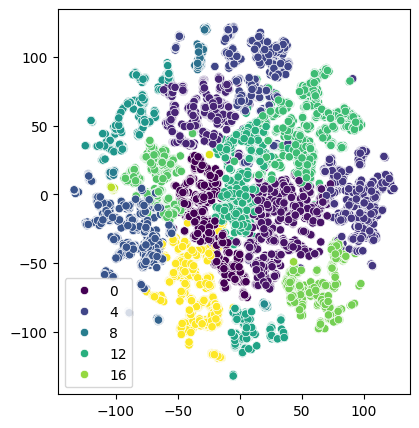

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=labse_tsne[:, 0], y=labse_tsne[:, 1], hue=labels, palette='viridis')

## Gaussian Mixture Model

In [ ]:
labels = gmm.predict(labse_df)

print("Silhouette Score (GMM):", silhouette_score(labse_df, labels))
print("Davies-Bouldin Index (GMM):", davies_bouldin_score(labse_df, labels))
print("Calinski-Harabasz Index (GMM):", calinski_harabasz_score(labse_df, labels))
print("Adjusted Rand Index (GMM vs. True Labels):", adjusted_rand_score(y_true, labels))
print("Normalized Mutual Information (GMM vs. True Labels):", normalized_mutual_info_score(y_true, labels))

Silhouette Score (GMM): 0.35743536046542573
Davies-Bouldin Index (GMM): 0.8600966385884629
Calinski-Harabasz Index (GMM): 8024.157528223845
Adjusted Rand Index (GMM vs. True Labels): 0.15481570903451844
Normalized Mutual Information (GMM vs. True Labels): 0.3383701066966498


<Axes: >

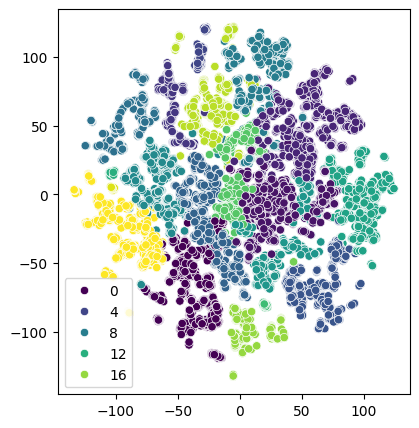

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=labse_tsne[:, 0], y=labse_tsne[:, 1], hue=labels, palette='viridis')

## Agglomerative clustering

In [ ]:
labels = agg.labels_

print("Silhouette Score (AGG):", silhouette_score(labse_df, labels))
print("Davies-Bouldin Index (AGG):", davies_bouldin_score(labse_df, labels))
print("Calinski-Harabasz Index (AGG):", calinski_harabasz_score(labse_df, labels))
print("Adjusted Rand Index (AGG vs. True Labels):", adjusted_rand_score(y_true, labels))
print("Normalized Mutual Information (AGG vs. True Labels):", normalized_mutual_info_score(y_true, labels))

Silhouette Score (AGG): 0.3112786987765346
Davies-Bouldin Index (AGG): 0.4234989467845218
Calinski-Harabasz Index (AGG): 3216.4803083958936
Adjusted Rand Index (AGG vs. True Labels): 0.11310696506063213
Normalized Mutual Information (AGG vs. True Labels): 0.25583526648730553


<Axes: >

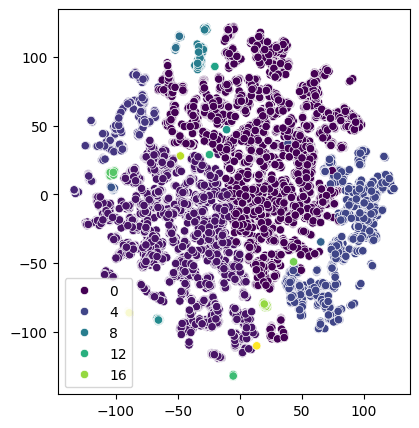

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=labse_tsne[:, 0], y=labse_tsne[:, 1], hue=labels, palette='viridis')

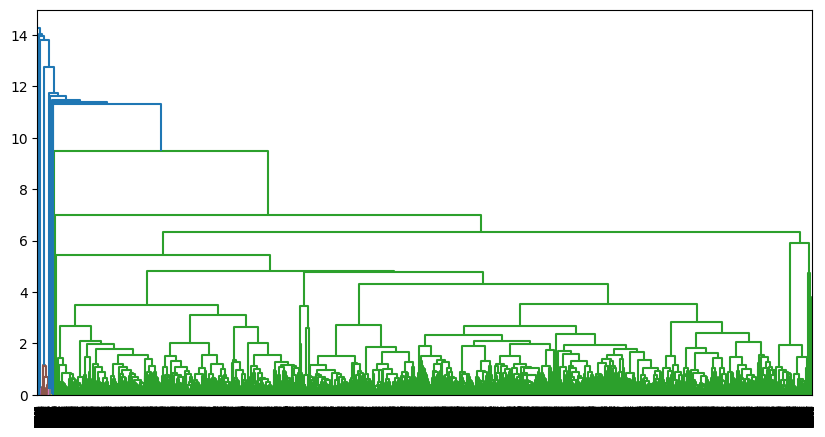

In [ ]:
linked = linkage(labse_df, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linked)
#plt.title('Dendrogram (Hierarchical Clustering)')
plt.show()

## MeanShift

In [ ]:
labels = ms.labels_

print("Silhouette Score (MeanShift):", silhouette_score(w2v_df, labels))
print("Davies-Bouldin Index (MeanShift):", davies_bouldin_score(w2v_df, labels))
print("Calinski-Harabasz Index (MeanShift):", calinski_harabasz_score(w2v_df, labels))
print("Adjusted Rand Index (MeanShift vs. True Labels):", adjusted_rand_score(y_true, labels))
print("Normalized Mutual Information (MeanShift vs. True Labels):", normalized_mutual_info_score(y_true, labels))

Silhouette Score (MeanShift): 0.4770119105722241
Davies-Bouldin Index (MeanShift): 0.6638993924319253
Calinski-Harabasz Index (MeanShift): 3272.257625199711
Adjusted Rand Index (MeanShift vs. True Labels): 0.012649487623165792
Normalized Mutual Information (MeanShift vs. True Labels): 0.0647097104469459


<Axes: >

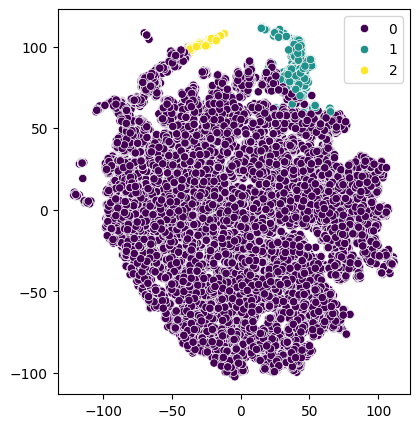

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=w2v_tsne[:, 0], y=w2v_tsne[:, 1], hue=labels, palette='viridis')

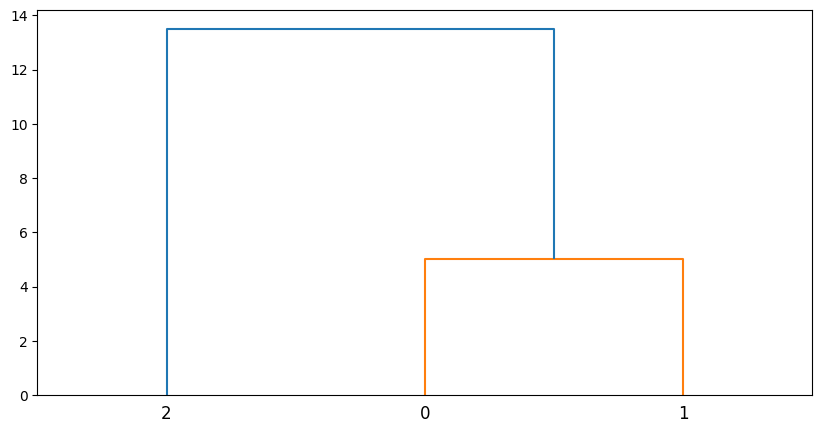

In [ ]:
meanshift_centroids = ms.cluster_centers_
linked_meanshift = linkage(meanshift_centroids, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked_meanshift)
plt.show()

## BIRCH

In [ ]:
labels = birch.labels_

print("Silhouette Score (BIRCH):", silhouette_score(labse_df, labels))
print("Davies-Bouldin Index (BIRCH):", davies_bouldin_score(labse_df, labels))
print("Calinski-Harabasz Index (BIRCH):", calinski_harabasz_score(labse_df, labels))
print("Adjusted Rand Index (BIRCH vs. True Labels):", adjusted_rand_score(y_true, labels))
print("Normalized Mutual Information (BIRCH vs. True Labels):", normalized_mutual_info_score(y_true, labels))

Silhouette Score (BIRCH): 0.6783183544792459
Davies-Bouldin Index (BIRCH): 0.9414463788122305
Calinski-Harabasz Index (BIRCH): 396.14242496630305
Adjusted Rand Index (BIRCH vs. True Labels): 0.0007752681806084852
Normalized Mutual Information (BIRCH vs. True Labels): 0.004514501709957273


<Axes: >

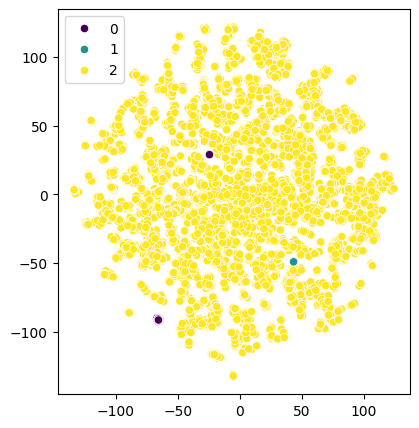

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=labse_tsne[:, 0], y=labse_tsne[:, 1], hue=labels, palette='viridis')

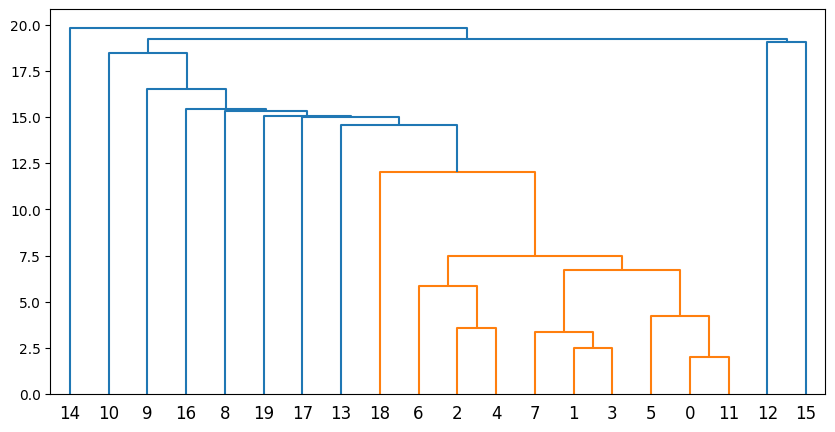

In [ ]:
birch_centroids = birch.subcluster_centers_
linked_birch = linkage(birch_centroids, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked_birch)
plt.show()

## Inner Cluster Predictions

In [ ]:
res_df['kmeans'] = kmeans.labels_
res_df['gmm'] = gmm.predict(labse_df)
res_df['agg'] = agg.labels_
res_df['meanshift'] = ms.labels_
res_df['birch'] = birch.labels_

<ipython-input-61-14d28ea65831>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['kmeans'] = kmeans.labels_
<ipython-input-61-14d28ea65831>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['gmm'] = gmm.predict(labse_df)
<ipython-input-61-14d28ea65831>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
res_df.to_csv(output_path+'res_df.csv', index=False)

In [ ]:
def clustering_distributions(cluster_column):
  contingency_table = pd.crosstab(res_df[cluster_column], res_df["gr_stat_letter"])

  # Plot a heatmap
  plt.figure(figsize=(15, 8))
  sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Distribution of gr_stat_letter in {cluster_column} Clusters")
  plt.xlabel("gr_stat_letter")
  plt.ylabel("Cluster")
  plt.show()

  # Identify pure clusters
  pure_clusters = (contingency_table.max(axis=1) / contingency_table.sum(axis=1)) > 0.9  # 90% purity threshold
  pure_clusters = pure_clusters[pure_clusters].index.tolist()

  print(f"Pure clusters (90% threshold): {pure_clusters}")


def proportion_distribution(cluster_column):
  # Create a contingency table (counts)
  contingency_table = pd.crosstab(res_df[cluster_column], res_df["gr_stat_letter"])

  # Normalize the table to get proportions
  contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)

  # Plot stacked bar chart
  contingency_table_normalized.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')

  plt.title(f"Proportion of gr_stat_letter in {cluster_column} Clusters")
  plt.xlabel("Cluster")
  plt.ylabel("Proportion")
  plt.legend(title="gr_stat_letter", bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

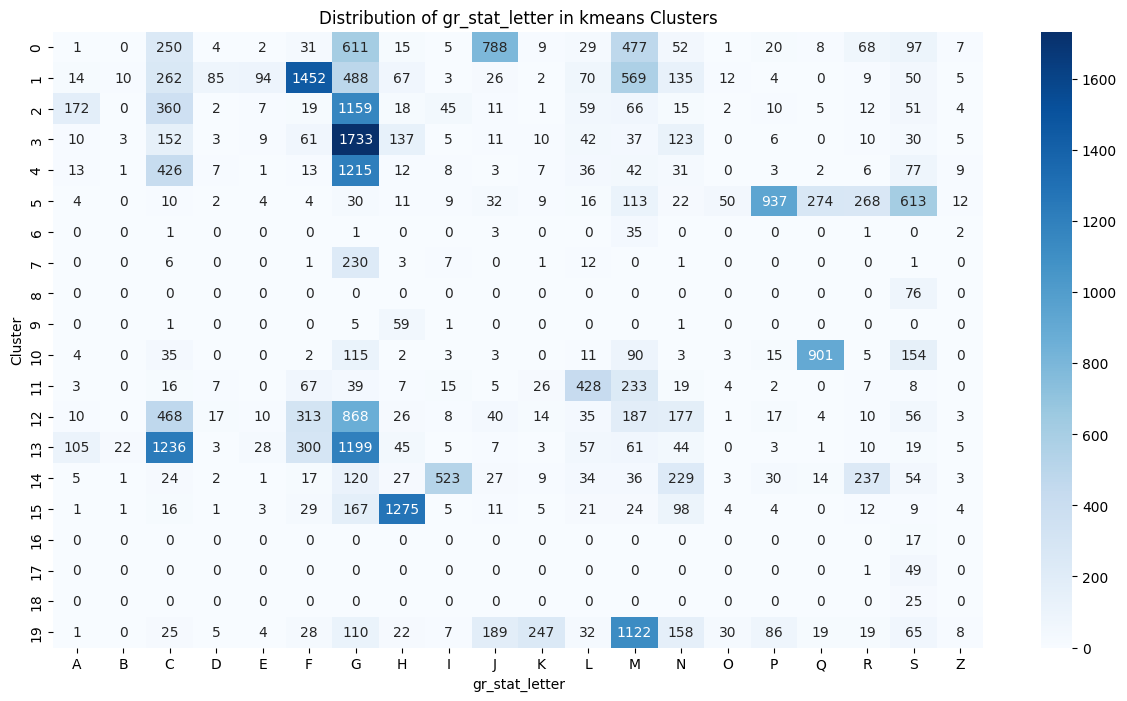

Pure clusters (90% threshold): [8, 16, 17, 18]


In [ ]:
clustering_distributions('kmeans')

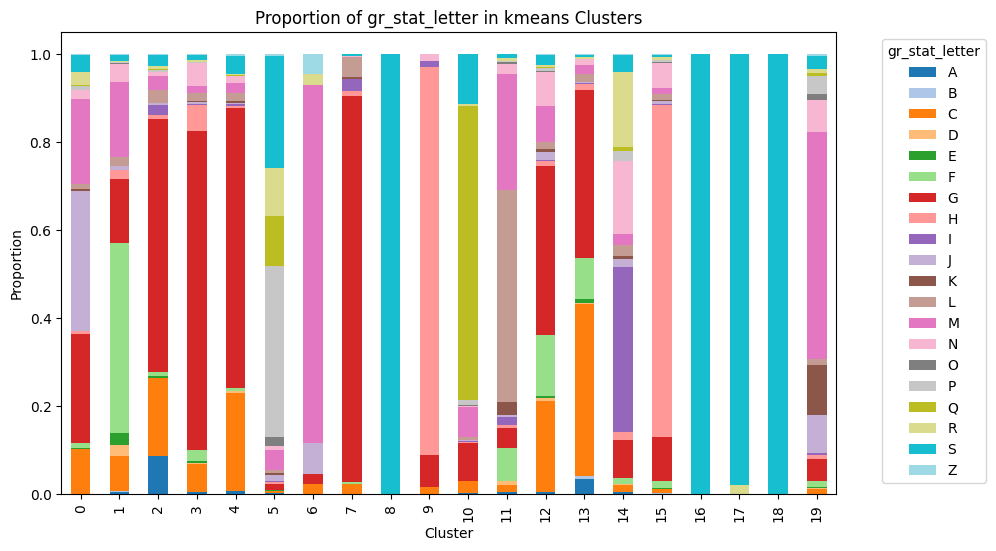

In [ ]:
proportion_distribution('kmeans')

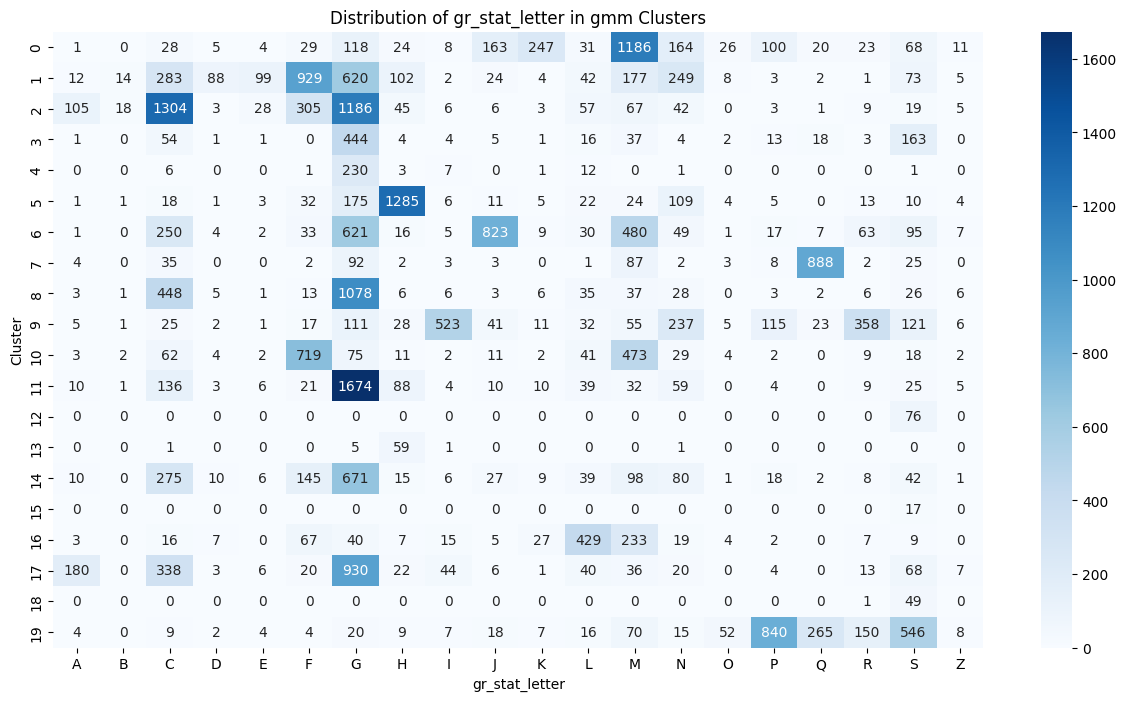

Pure clusters (90% threshold): [12, 15, 18]


In [ ]:
clustering_distributions('gmm')

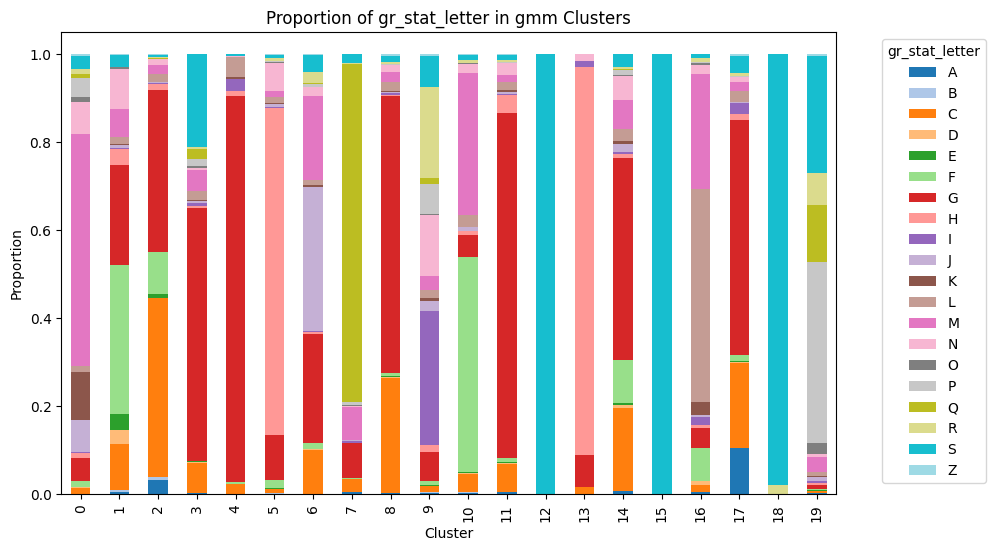

In [ ]:
proportion_distribution('gmm')

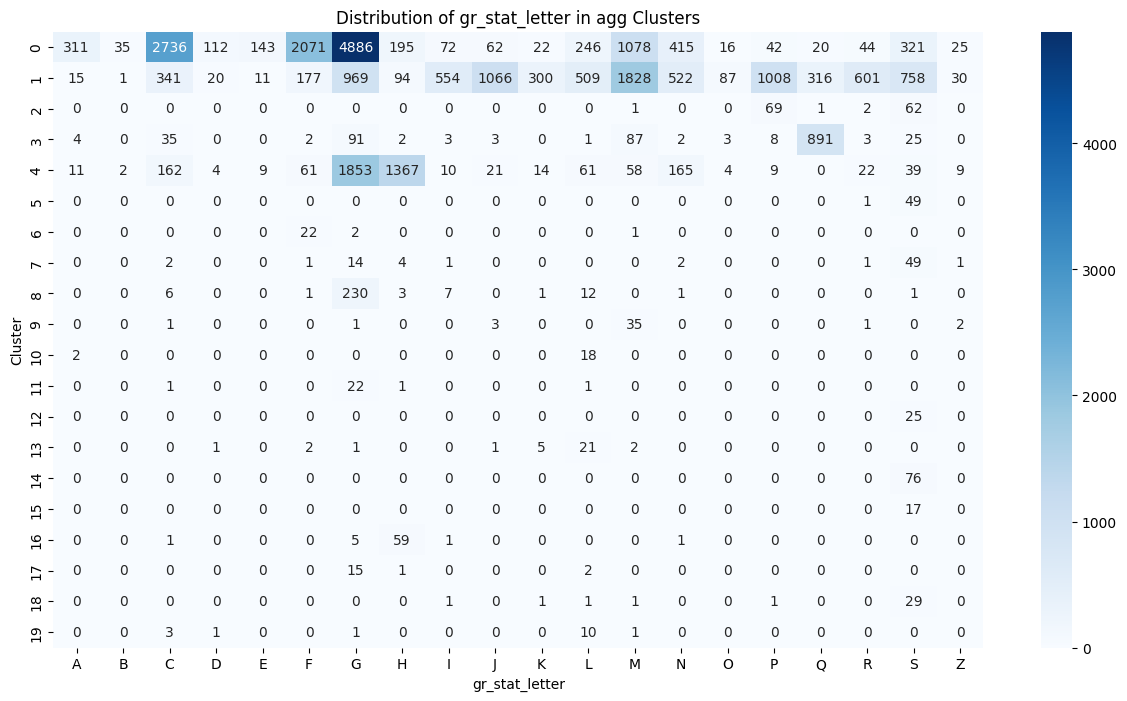

Pure clusters (90% threshold): [5, 12, 14, 15]


In [ ]:
clustering_distributions('agg')

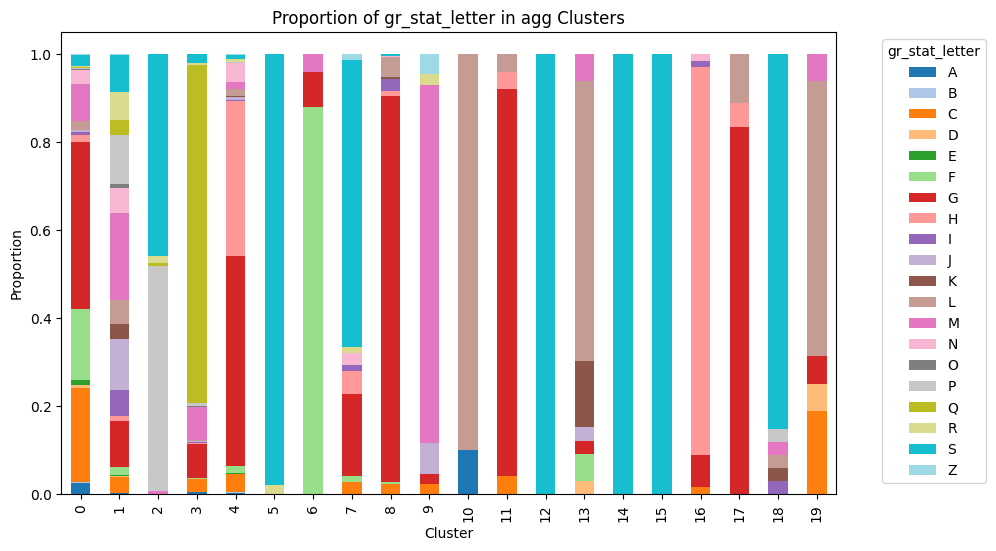

In [ ]:
proportion_distribution('agg')

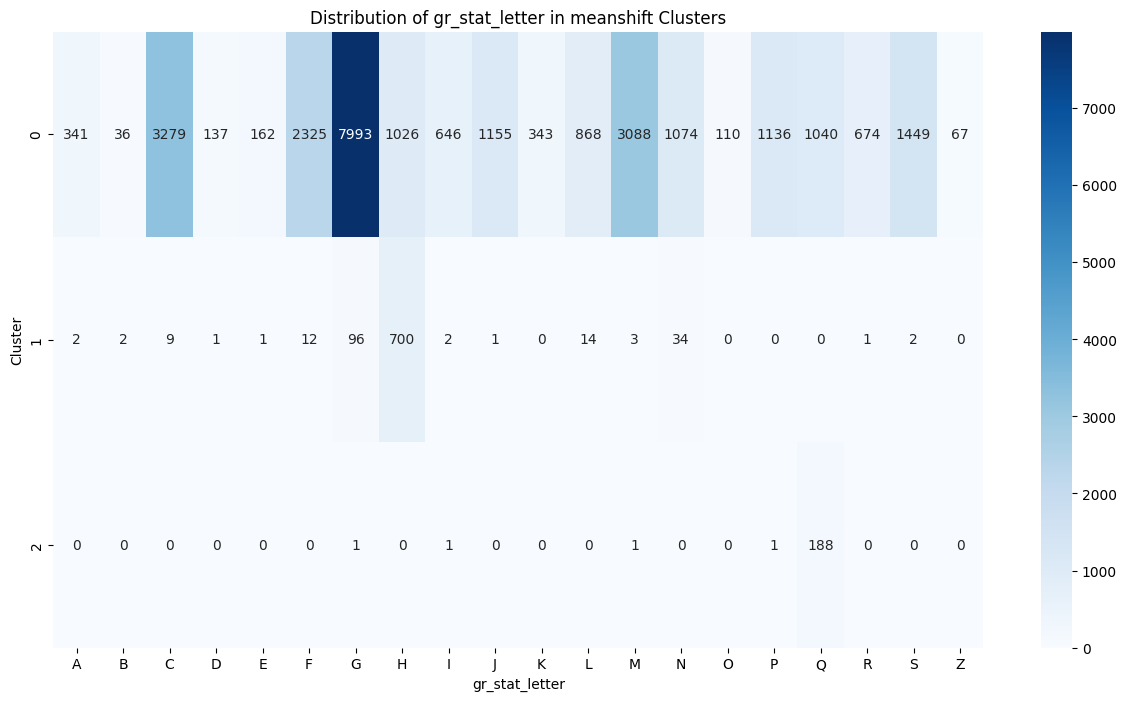

Pure clusters (90% threshold): [2]


In [ ]:
clustering_distributions('meanshift')

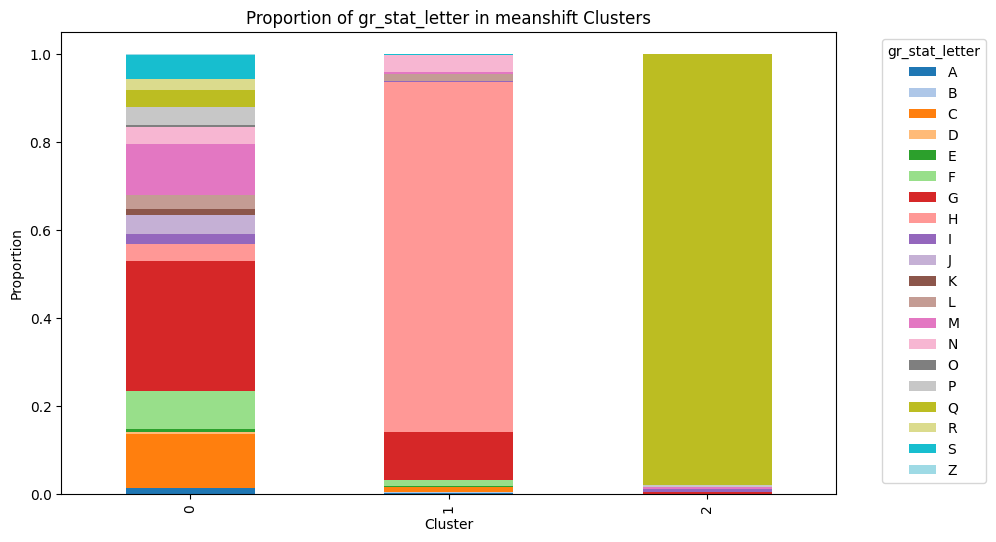

In [ ]:
proportion_distribution('meanshift')

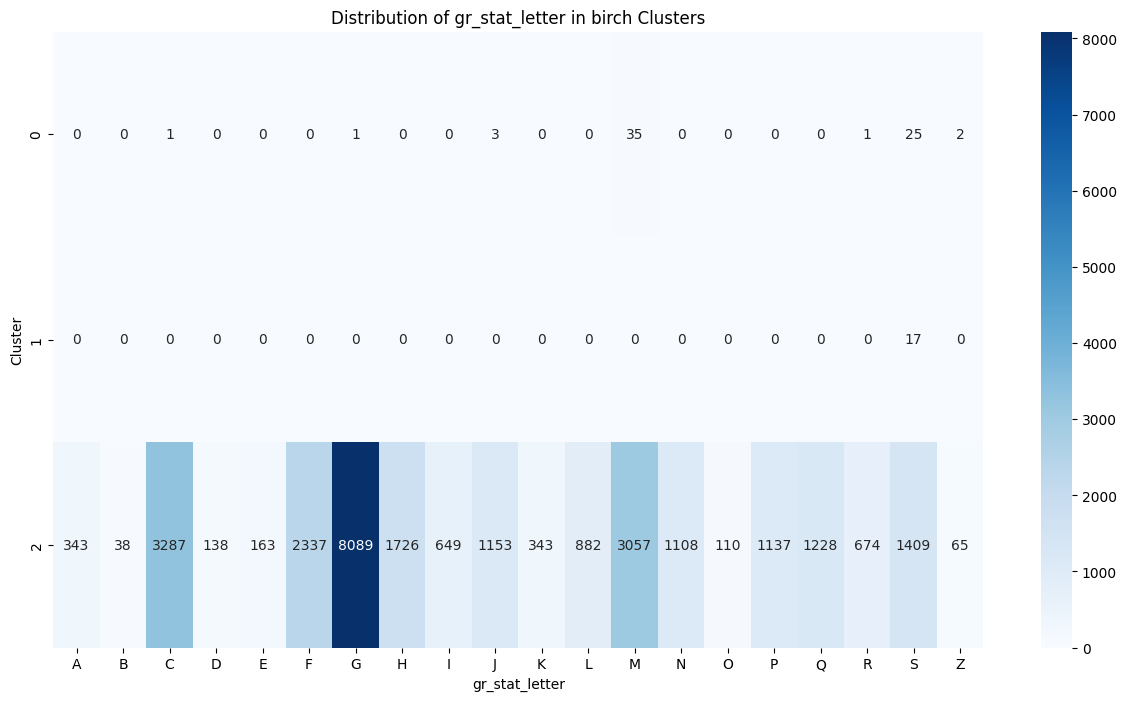

Pure clusters (90% threshold): [1]


In [ ]:
clustering_distributions('birch')

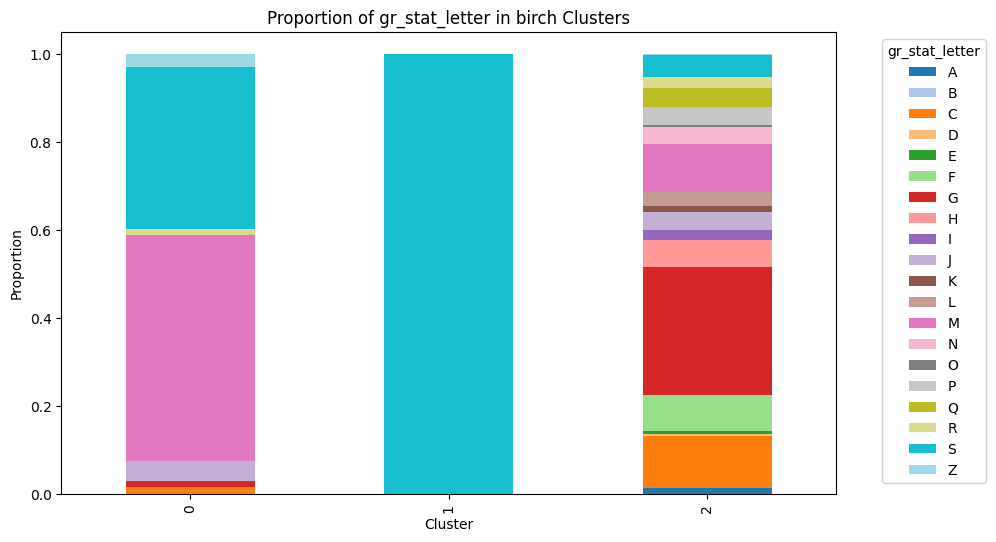

In [ ]:
proportion_distribution('birch')